In [1]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sn
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [2]:
df_train = pd.read_csv('forest-cover-type-prediction/train.csv')
df_train.sample(5)

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
1459    1460       2827      84     46                               134   
1680    1681       3244     184     15                               180   
12397  12398       2199     135     31                               212   
14144  14145       2858     137     25                               726   
1111    1112       3152      69     11                                60   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
1459                               -2                              295   
1680                               26                             2877   
12397                             121                              685   
14144                              79                             2240   
1111                                4                             5490   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
1459             233             118              0  ...            0   
1680             223             249            155  ...            0   
12397            250             210             64  ...            0   
14144            249             222             86  ...            0   
1111             232             218            116  ...            0   

       Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
1459             0            0            0            0            0   
1680             0            0            0            0            0   
12397            0            0            0            0            0   
14144            0            0            0            0            0   
1111             0            0            0            0            0   

       Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
1459             0            0            0           5  
1680             0            0            0           7  
12397            0            0            0           4  
14144            0            0            0           5  
1111             0            0            0           2  

[5 rows x 56 columns]

## Data Transformations

In [3]:
# normalization
from sklearn.preprocessing import normalize

col_normalize = ['Elevation', 'Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
#df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn import model_selection

In [5]:
np.set_printoptions(precision=5)
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.13, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('\nModel:',type(model).__name__)
    print('\tcv acc:', round(results.mean(),4))
    print('\tsplit acc:', round(acc,4))
    print('\ttime taken:', round(end-start, 4))
    if display:
        matrix = cm(y_val, pred)
        print('\t', matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

# Data filtering to Cat 1 and 2

In [6]:
maska = df_train_norm['Cover_Type']==1
maskb = df_train_norm['Cover_Type']==2
mask = maska | maskb
df_1_2 = df_train_norm[mask]

# Heatmap by sub-selection of highly confounded Cover_Types

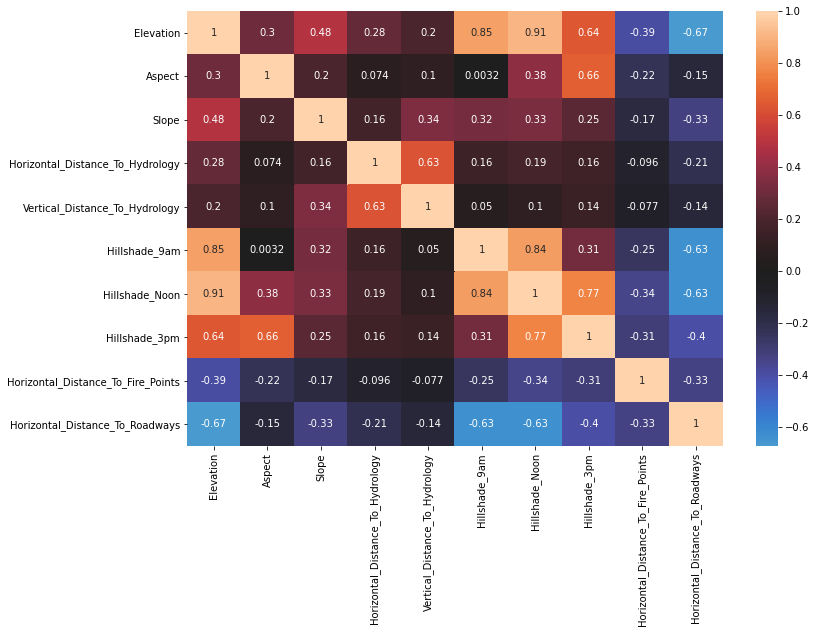

In [7]:
# looking more closely at covers 1 and 2
fig = plt.figure(1, figsize=(12, 8))
small_ab_eda = df_train_norm[mask][col_normalize]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

# ExtraTreesClassifier

ExtraTreesClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

# Model for cover_types 1 and 2 only

In [8]:
if False:
    mod_1_2 = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0),df_1_2)

# Neural Network

In [9]:
X = df_train_norm.iloc[:,1:-1]
y = df_train_norm.iloc[:,-1:]

from keras.utils import np_utils
y_enc = np_utils.to_categorical(y)
y_enc[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [73]:
import tensorflow.keras as keras

def create_model(input_size=54, output_size=8):
    # create model
    initializer = None #keras.initializers.RandomNormal(mean=0., stddev=1.)
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(input_size,)))
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
    model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=initializer))
    model.add(keras.layers.Dropout(rate=.1))
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
    model.add(keras.layers.Dense(64, activation='relu', kernel_initializer=initializer))
    model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=initializer))
    model.add(keras.layers.Dropout(rate=.1))
    model.add(keras.layers.Dense(output_size, activation='softmax', kernel_initializer=initializer))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [74]:
from keras.wrappers.scikit_learn import KerasClassifier

kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X, np.array(y_enc), test_size=.13, random_state=0)

model_val = KerasClassifier(build_fn=create_model, epochs=0, batch_size=32, verbose=0)

start = time.time()
results = model_selection.cross_val_score(model_val, X_train.values, y_train, cv=kfold)
model_val.fit(X_train.values, y_train, batch_size=16, epochs=200, verbose=2)

pred = model_val.predict(X_val.values)
acc = accuracy_score(np.argmax(y_val, axis=1), pred)
end = time.time()

print('\nModel:',type(model_val).__name__)
print('\tcv acc:', round(results.mean(),4))
print('\tsplit acc:', round(acc,4))
print('\ttime taken:', round(end-start, 4))


Epoch 1/200
823/823 - 1s - loss: 1.0669 - accuracy: 0.5512
Epoch 2/200
823/823 - 1s - loss: 0.9125 - accuracy: 0.6165
Epoch 3/200
823/823 - 1s - loss: 0.8539 - accuracy: 0.6392
Epoch 4/200
823/823 - 1s - loss: 0.8073 - accuracy: 0.6648
Epoch 5/200
823/823 - 1s - loss: 0.7678 - accuracy: 0.6785
Epoch 6/200
823/823 - 1s - loss: 0.7340 - accuracy: 0.6895
Epoch 7/200
823/823 - 1s - loss: 0.7070 - accuracy: 0.7004
Epoch 8/200
823/823 - 1s - loss: 0.6794 - accuracy: 0.7075
Epoch 9/200
823/823 - 1s - loss: 0.6571 - accuracy: 0.7181
Epoch 10/200
823/823 - 1s - loss: 0.6370 - accuracy: 0.7303
Epoch 11/200
823/823 - 1s - loss: 0.6228 - accuracy: 0.7371
Epoch 12/200
823/823 - 1s - loss: 0.6088 - accuracy: 0.7461
Epoch 13/200
823/823 - 1s - loss: 0.5982 - accuracy: 0.7503
Epoch 14/200
823/823 - 1s - loss: 0.5743 - accuracy: 0.7590
Epoch 15/200
823/823 - 1s - loss: 0.5726 - accuracy: 0.7598
Epoch 16/200
823/823 - 1s - loss: 0.5574 - accuracy: 0.7681
Epoch 17/200
823/823 - 1s - loss: 0.5433 - accura

823/823 - 1s - loss: 0.2171 - accuracy: 0.9107
Epoch 138/200
823/823 - 1s - loss: 0.2143 - accuracy: 0.9110
Epoch 139/200
823/823 - 1s - loss: 0.2077 - accuracy: 0.9161
Epoch 140/200
823/823 - 1s - loss: 0.2036 - accuracy: 0.9130
Epoch 141/200
823/823 - 1s - loss: 0.2018 - accuracy: 0.9148
Epoch 142/200
823/823 - 1s - loss: 0.2043 - accuracy: 0.9159
Epoch 143/200
823/823 - 1s - loss: 0.2098 - accuracy: 0.9121
Epoch 144/200
823/823 - 1s - loss: 0.2014 - accuracy: 0.9151
Epoch 145/200
823/823 - 1s - loss: 0.2024 - accuracy: 0.9155
Epoch 146/200
823/823 - 1s - loss: 0.2105 - accuracy: 0.9116
Epoch 147/200
823/823 - 1s - loss: 0.2076 - accuracy: 0.9125
Epoch 148/200
823/823 - 1s - loss: 0.2006 - accuracy: 0.9131
Epoch 149/200
823/823 - 1s - loss: 0.2030 - accuracy: 0.9146
Epoch 150/200
823/823 - 1s - loss: 0.1996 - accuracy: 0.9160
Epoch 151/200
823/823 - 1s - loss: 0.1914 - accuracy: 0.9195
Epoch 152/200
823/823 - 1s - loss: 0.2053 - accuracy: 0.9139
Epoch 153/200
823/823 - 1s - loss: 0.2

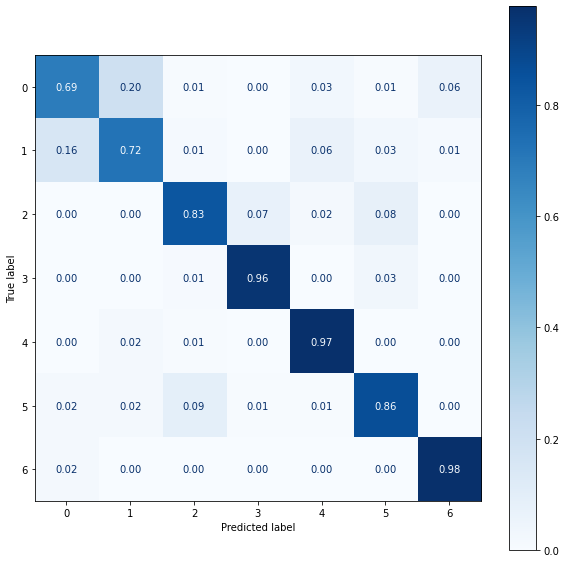

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(y_val, axis=1), pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
obj_classes_desc = [str(i) for i in range(0,8)]
cm_disp = ConfusionMatrixDisplay(cm, display_labels=obj_classes_desc)
cm_disp.plot(values_format='.2f', ax=ax, cmap='Blues')

# Modeling for Types 1 and 2 only:  Did not change result

In [ ]:
if False:
    X_1_2 = df_1_2.iloc[:,1:-1]
    y_1_2 = df_1_2.iloc[:,-1:]

    from keras.utils import np_utils
    y_1_2_enc = np_utils.to_categorical(y_1_2)

    model_1_2 = create_model(X_1_2.shape[1], y_1_2_enc.shape[1])
    history = model_1_2.fit(X_1_2.values, y_1_2_enc, 
                          batch_size=32, epochs=300, 
                          verbose=2, validation_split=0.2)

In [ ]:
if False:
    y_1_2_pred = model.predict(X_1_2.values)
    y_1_2_pred = np.argmax(y_1_2_pred, axis=1)+1

    cm_1_2 = confusion_matrix(y_1_2, y_1_2_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(10, 10))
    obj_classes_desc = [str(i) for i in range(0,3)]
    cm_1_2_disp = ConfusionMatrixDisplay(cm_1_2, display_labels=obj_classes_desc)
    cm_1_2_disp.plot(values_format='.2f', ax=ax, cmap='Blues')

In [ ]:
if False:
    model_eval = model_1_2.evaluate(X_1_2.values, y_1_2_enc, return_dict=True)

# Shap analysis for full model

In [ ]:
import tensorflow as tf 
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import keras

In [ ]:
model_shap = create_model(X.shape[1], y_enc.shape[1])
history_shap = model_shap.fit(X.values, y_enc, 
                      batch_size=32, epochs=300, 
                      verbose=0, validation_split=0.2)

In [ ]:
import shap
shap.initjs()

explainer_shap = shap.DeepExplainer(model_shap, data=X)

In [ ]:
# Fit the explainer on a subset of the data (you can try all but then gets slower)
    # 5000 records takes approx 5 minutes on CPU
    # 15k records takes 60 mins on CPU
shap_values = explainer_shap.shap_values(X=X.values[:],
                                      ranked_outputs=True,check_additivity=False)

In [ ]:
# 500 records on the 5k-record model takes approx 2 minutes
# 500 records on the 15k-record model takes approx 15 minutes

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0],
                feature_names=X.columns)

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0][1],
                X.values[:500][0],
                feature_names=X.columns,)

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0][1],
                X.values[:500][0],
                feature_names=X.columns,)

## Next blocks not working correctly

In [ ]:
sample_num = 1 
base_value = explainer_shap.expected_value
output= base_value + np.sum(shap_values[0][0][sample_num])
print('base value: ',base_value)
print('output value: ',output)

#sanity check that the output value is equal to the actual prediction
print(np.round(output,decimals=1) == np.round(model_shap.predict(X.values)[sample_num],decimals=1))

# to get the shape values for each feature
shap_df = pd.DataFrame(list(dict(zip(X.columns.values,base_value)).items()),
             columns=['features','shapvals']).sort_values(by='shapvals', ascending=True)
print(shap_df)

In [ ]:
X.columns.values

In [ ]:
shap_values[0][0].shape